<h1>Using Dropout in Regression</h1>

<h2>Table of Contents</h2>
<p>In this notebook, we will see how adding dropout to your model will decrease overfitting.</p>

<ul>
    <li><a href="#Makeup_Data">Make Some Data</a></li>
    <li><a href="#Model_Cost">Create the Model and Cost Function the PyTorch way</a></li>
    <li><a href="#BGD">Batch Gradient Descent</a></li>
</ul>

<hr>

<h2>Preparation</h2>

We'll need the following libraries

In [3]:
# Import the libraries we need for the lab

import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(0) 

<!--Empty Space for separating topics-->

<h2 id="Makeup_Data">Make Some Data</h2>

Create polynomial dataset class: 

In [10]:
# Create Data object

class Data(Dataset):
    
    # Constructor
    def __init__(self, N_SAMPLES=40, noise_std=1, train=True):
        self.x = torch.linspace(-1, 1, N_SAMPLES).view(-1, 1)
        self.f = self.x ** 2
        if train != True:
            torch.manual_seed(1)
            self.y = self.f + noise_std * torch.randn(self.f.size())
            self.y = self.y.view(-1, 1)
            torch.manual_seed(0)
        else:
            self.y = self.f + noise_std * torch.randn(self.f.size())
            self.y = self.y.view(-1, 1)
            
    # Getter
    def __getitem__(self, index):    
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len
    
    # Plot the data
    def plot(self):
        plt.figure(figsize = (6.1, 10))
        plt.scatter(self.x.numpy(), self.y.numpy(), label="Samples")
        plt.plot(self.x.numpy(), self.f.numpy() ,label="True Function", color='orange')
        plt.xlabel("x")
        plt.ylabel("y")
        plt.xlim((-1, 1))
        plt.ylim((-2, 2.5))
        plt.legend(loc="best")
        plt.show()

Create a dataset object:

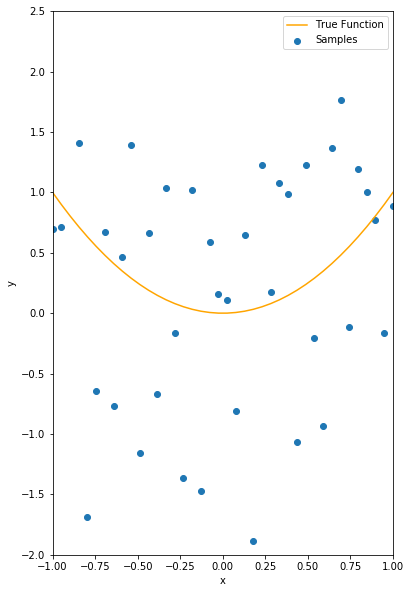

In [11]:
# Create the dataset object and plot the dataset

data_set = Data()
data_set.plot()

Get some validation data: 

In [12]:
# Create validation dataset object

validation_set = Data(train=False)

<!--Empty Space for separating topics-->

<h2 id="Model_Cost">Create the Model, Optimizer, and Total Loss Function (Cost)</h2>

Create a custom module with three layers. <code>in_size</code> is the size of the input features, <code>n_hidden</code> is the size of the layers, and <code>out_size</code> is the size. <code>p</code> is dropout probability. The default is 0 which is no dropout.

In [13]:
# Create the class for model

class Net(nn.Module):
    
    # Constructor
    def __init__(self, in_size, n_hidden, out_size, p=0):
        super(Net, self).__init__()
        self.drop = nn.Dropout(p=p)
        self.linear1 = nn.Linear(in_size, n_hidden)
        self.linear2 = nn.Linear(n_hidden, n_hidden)
        self.linear3 = nn.Linear(n_hidden, out_size)
        
    def forward(self, x):
        x = F.relu(self.drop(self.linear1(x)))
        x = F.relu(self.drop(self.linear2(x)))
        x = self.linear3(x)
        return x

Create two model objects: <code>model</code> had no dropout, and <code>model_drop </cdoe> has a dropout probability of 0.5:

In [14]:
# Create the model objects

model = Net(1, 300, 1)
model_drop = Net(1, 300, 1, p=0.5)

<!--Empty Space for separating topics-->

<h2 id="Train">Train the Model via Mini-Batch Gradient Descent</h2>

Set the model using dropout to training mode; this is the default mode, but it's good practice. 

In [15]:
# Set the model to train mode

model_drop.train()

Net(
  (drop): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=1, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=300, bias=True)
  (linear3): Linear(in_features=300, out_features=1, bias=True)
)

Train the model by using the Adam optimizer. See the unit on other optimizers. Use the mean square loss: 

In [16]:
# Set the optimizer and criterion function

optimizer_ofit = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer_drop = torch.optim.Adam(model_drop.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

Initialize a dictionary that stores the training and validation loss for each model:

In [17]:
# Initialize the dict to contain the loss results

LOSS={}
LOSS['training data no dropout']=[]
LOSS['validation data no dropout']=[]
LOSS['training data dropout']=[]
LOSS['validation data dropout']=[]

Run 500 iterations of batch gradient descent: 

In [18]:
# Train the model

epochs = 500

def train_model(epochs):
    for epoch in range(epochs):
        yhat = model(data_set.x)
        yhat_drop = model_drop(data_set.x)
        loss = criterion(yhat, data_set.y)
        loss_drop = criterion(yhat_drop, data_set.y)

        #store the loss for  both the training and validation  data for both models 
        LOSS['training data no dropout'].append(loss.item())
        LOSS['validation data no dropout'].append(criterion(model(validation_set.x), validation_set.y).item())
        LOSS['training data dropout'].append(loss_drop.item())
        model_drop.eval()
        LOSS['validation data dropout'].append(criterion(model_drop(validation_set.x), validation_set.y).item())
        model_drop.train()

        optimizer_ofit.zero_grad()
        optimizer_drop.zero_grad()
        loss.backward()
        loss_drop.backward()
        optimizer_ofit.step()
        optimizer_drop.step()
        
train_model(epochs)

Set the model with dropout to evaluation mode:

In [19]:
# Set the model with dropout to evaluation mode

model_drop.eval()

Net(
  (drop): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=1, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=300, bias=True)
  (linear3): Linear(in_features=300, out_features=1, bias=True)
)

Make a prediction by using both models: 

In [23]:
# Make the prediction

yhat = model(validation_set.x)
yhat_drop = model_drop(validation_set.x)

Plot predictions of both models. Compare them to the training points and the true function: 

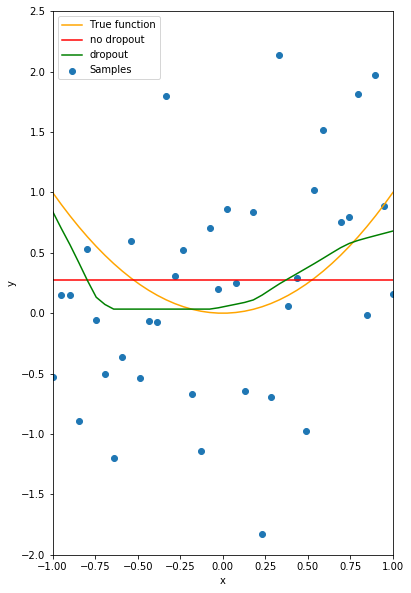

In [25]:
# Plot the predictions for both models

plt.figure(figsize=(6.1, 10))

plt.scatter(validation_set.x.numpy(), validation_set.y.numpy(), label="Samples")
plt.plot(data_set.x.numpy(), data_set.f.numpy(), label="True function", color='orange')
plt.plot(validation_set.x.numpy(), yhat.detach().numpy(), label='no dropout', c='r')
plt.plot(validation_set.x.numpy(), yhat_drop.detach().numpy(), label="dropout", c ='g')

plt.xlabel("x")
plt.ylabel("y")
plt.xlim((-1, 1))
plt.ylim((-2, 2.5))
plt.legend(loc = "best")
plt.show()

You can see that the model using dropout does better at tracking the function that generated the data. We use the log to make the difference more apparent 

Plot out the loss for training and validation data on both models:  

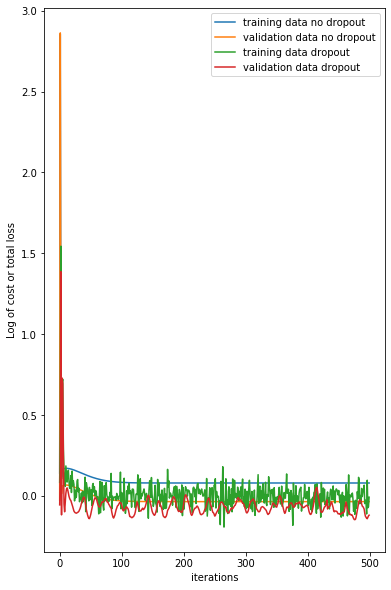

In [26]:
# Plot the loss

plt.figure(figsize=(6.1, 10))
for key, value in LOSS.items():
    plt.plot(np.log(np.array(value)), label=key)
    plt.legend()
    plt.xlabel("iterations")
    plt.ylabel("Log of cost or total loss")

You see that the model without dropout performs better on the training data, but it performs worse on the validation data. This suggests overfitting.  However, the model using dropout performs better on the validation data, but worse on the training data. 

<!--Empty Space for separating topics-->

<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD. 

Other contributors: <a href="https://www.linkedin.com/in/michelleccarey/">Michelle Carey</a>, <a href="www.linkedin.com/in/jiahui-mavis-zhou-a4537814a">Mavis Zhou</a>

<hr>

Copyright &copy; 2018 <a href="cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu">cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.